In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_steam.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 08:30:00     94.000000
2013-03-20 08:45:00     99.500000
2013-03-20 09:00:00    104.699997
2013-03-20 09:15:00    109.650002
2013-03-20 09:30:00    114.849998
2013-03-20 09:45:00    120.050003
2013-03-20 10:00:00    124.949997
2013-03-20 10:15:00    130.000000
2013-03-20 10:30:00    134.949997
2013-03-20 10:45:00    139.899994
2013-03-20 11:00:00    144.699997
2013-03-20 11:15:00    149.600006
2013-03-20 11:30:00    154.250000
2013-03-20 11:45:00    158.600006
2013-03-20 12:00:00    162.750000
2013-03-20 12:15:00    167.000000
2013-03-20 12:30:00    171.250000
2013-03-20 12:45:00    175.449997
2013-03-20 13:00:00    179.550003
2013-03-20 13:15:00    183.449997
2013-03-20 13:30:00    187.500000
2013-03-20 13:45:00    191.500000
2013-03-20 14:00:00    195.500000
2013-03-20 14:15:00    199.600006
2013-03-20 14:30:00    203.649994
2013-03-20 14:45:00    207.550003
2013-03-20 15:00:00    211.550003
2013-03-20 15:15:00

In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                31550
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -163747.736
Method:                           css   S.D. of innovations             43.431
Date:                Tue, 07 Jul 2015   AIC                         327499.472
Time:                        14:49:54   BIC                         327516.190
Sample:                    03-20-2013   HQIC                        327504.823
                         - 02-12-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0043      0.245      0.018      0.986        -0.475     0.484


We see that ARIMA is not currently fitting the time series data. We look for an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    31550.000000
mean         0.000028
std          0.641424
min         -8.194782
5%           0.000827
50%          0.032174
95%          0.236389
max          2.136600
Name: steam values, dtype: float64


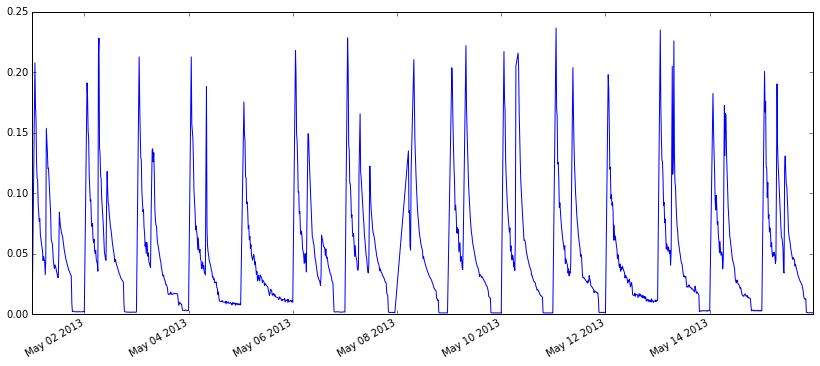

In [3]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
basic_stats = park_ts_logr.describe(percentiles=[0.05, 0.95])

print(basic_stats)
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

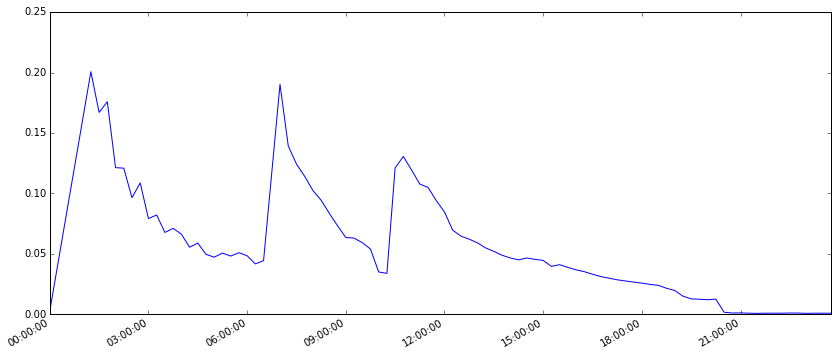

In [4]:
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                -455.090
Date:                            Tue, 07 Jul 2015   AIC                            914.180
Time:                                    14:49:55   BIC                            922.528
Sample:                                05-06-2013   HQIC                           917.462
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.1445      0.050     -2.884      0.004        -0.243    -0.046
sigma2         0.6265      0.043     14.566      0.000         0.542     0.711


While the fit isn't terrible, it perhaps can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of consecutive values dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [14]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > basic_stats['5%']]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                  93.109
Date:                            Tue, 07 Jul 2015   AIC                           -182.217
Time:                                    14:55:26   BIC                           -174.058
Sample:                                05-06-2013   HQIC                          -178.998
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.4511      0.041     10.870      0.000         0.370     0.532
sigma2         0.0339      0.002     13.706      0.000         0.029     0.039


The positives of smoothing the data via filtration have been outweighed by the loss of data points to fit.  

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3112
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3325.059
Date:                            Tue, 07 Jul 2015   AIC                          -6646.118
Time:                                    14:50:03   BIC                          -6634.032
Sample:                                05-06-2013   HQIC                         -6641.779
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5443      0.012     44.757      0.000         0.521     0.568
sigma2         0.0065      0.000     38.644      0.000         0.006     0.007


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 8898
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                9085.122
Date:                            Tue, 07 Jul 2015   AIC                         -18166.243
Time:                                    14:50:12   BIC                         -18152.056
Sample:                                05-06-2013   HQIC                        -18161.413
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5270      0.007     71.414      0.000         0.513     0.541
sigma2         0.0074      0.000     64.104      0.000         0.007     0.008


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood               -1620.493
Date:                            Tue, 07 Jul 2015   AIC                           3244.986
Time:                                    14:50:49   BIC                           3259.222
Sample:                                05-06-2013   HQIC                          3249.827
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.1199      0.010    -11.629      0.000        -0.140    -0.100
sigma2         0.0838      0.001     68.755      0.000         0.081     0.086


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times separate from the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [15]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4295
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3876.551
Date:                            Tue, 07 Jul 2015   AIC                          -7749.101
Time:                                    14:59:41   BIC                          -7736.371
Sample:                                03-25-2013   HQIC                         -7744.605
                                     - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5560      0.010     54.588      0.000         0.536     0.576
sigma2         0.0092      0.000     46.857      0.000         0.009     0.010
                                 Statespace Mod

Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4512
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               -4738.263
Date:                            Tue, 07 Jul 2015   AIC                           9480.527
Time:                                    14:52:31   BIC                           9493.356
Sample:                                03-25-2013   HQIC                          9485.047
                                     - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.4907      0.013    -37.205      0.000        -0.517    -0.465
sigma2         0.5003      0.011     46.801      0.000         0.479     0.521
                                 Statespace Mod

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -69.892
Method:                           css   S.D. of innovations              1.106
Date:                Tue, 07 Jul 2015   AIC                            143.784
Time:                        14:53:11   BIC                            147.441
Sample:                    04-01-2013   HQIC                           145.154
                         - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0169      0.163      0.104      0.918        -0.303     0.336


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 147.053
Method:                           css   S.D. of innovations              0.010
Date:                Tue, 07 Jul 2015   AIC                           -290.106
Time:                        14:53:11   BIC                           -286.449
Sample:                    04-01-2013   HQIC                          -288.736
                         - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0002      0.001      0.116      0.908        -0.003     0.003


Observe that the fit has improved.